# Network Packet Analysis using Python

Dependencies

In [1]:
!pip install scapy
!wget https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-91/capture.botnet2.infected.1.pcap # the link to download pcap file

     |████████████████████████████████| 1.1MB 5.0MB/s 
  Created wheel for scapy: filename=scapy-2.4.5-py2.py3-none-any.whl size=1261554 sha256=df0d5bec67e64607e5f5b6466114546474833cd314e922d5933ebc7edf303186
  Stored in directory: /root/.cache/pip/wheels/31/80/dc/d5fc39b70e1af4f4636356c849de414a76e83a89d8ee9cd78f
Successfully built scapy
--2021-07-09 03:15:07--  https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-91/capture.botnet2.infected.1.pcap
Resolving mcfp.felk.cvut.cz (mcfp.felk.cvut.cz)... 147.32.82.194
Connecting to mcfp.felk.cvut.cz (mcfp.felk.cvut.cz)|147.32.82.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27738197 (26M) [application/vnd.tcpdump.pcap]
Saving to: ‘capture.botnet2.infected.1.pcap’

capture.botnet2.inf 100%[===================>]  26.45M  1.53MB/s    in 28s     

2021-07-09 03:15:36 (961 KB/s) - ‘capture.botnet2.infected.1.pcap’ saved [27738197/27738197]



Imports

In [2]:
from scapy.all import *
from scapy.layers.dns import DNS, DNSQR, DNSRR
from tqdm import tqdm #Progress bar [Can be used only for loops]
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

Reading packets from pcap file

In [ ]:
pkts = rdpcap('capture.botnet2.infected.1.pcap') # Reading and storing the packets in 'pkts'

### Task 1

1. Generate a CSV file of all DNS queries. Each line in this CSV file indicates a DNS query, which includes the 
timestamp, the source IP address, the destination IP address, and the domain name in this DNS query.

In [ ]:
def create_dns_queries(pkts):
  """
  Function to return a list of all the dns queries
  :param pkts: PacketList

  returns (list)
  """
  dns_queries = []
  for packet in tqdm(pkts): # iterating through the packets
    if packet.haslayer(DNS):
      t = {
        'time': packet.time,
        'src': packet.getlayer(IP).src if packet.haslayer(IP) else np.nan,
        'dst': packet[IP].dst if packet.haslayer(IP) else np.nan,
        'domain': np.nan,
        'record_type': np.nan
      }
      if packet.haslayer(DNSRR):
        t['domain'] = packet[DNSRR].rrname.decode()
        t['record_type'] = packet[DNSRR].get_field('type').i2repr(packet, packet[DNSRR].type)
      elif packet.haslayer(DNSQR):
        t['domain'] = packet[DNSQR].qname.decode()
        t['record_type'] = packet[DNSQR].get_field('qtype').i2repr(packet, packet[DNSQR].qtype)
      dns_queries.append(t) # Appending the dictionary 't' to list 'dns_queries'
  return dns_queries

  
df = pd.DataFrame(create_dns_queries(pkts)) # Creating DataFrame 'df' from the list 'dns_queries'
df.to_csv('Task1.csv', index=False) # Converting 'df' to csv file 'Task1.csv'

100%|██████████| 198818/198818 [00:09<00:00, 20985.96it/s]


Sample of first 10 entries in the 'Task1.csv'

In [ ]:
df[:10]

,time,src,dst,domain,record_type
0,1252782452.901660,192.168.1.55,224.0.0.251,186.182.88.77.in-addr.arpa.,PTR
1,1252782453.229651,200.51.43.5,192.168.1.236,baxall.com.,MX
2,1252782453.229667,192.168.1.236,192.168.5.1,baxall.com.,MX
3,1252782453.241589,192.168.1.91,192.168.5.1,uppinghm.demon.co.uk.,MX
4,1252782453.304021,192.168.1.91,200.51.43.5,uppington1975.wanadoo.co.uk.,MX
5,1252782453.305735,200.51.43.5,192.168.1.91,uppington1975.wanadoo.co.uk.,MX
6,1252782453.306443,192.168.1.91,200.51.43.5,uppington1975.wanadoo.co.uk.,MX
7,1252782453.307320,200.51.43.5,192.168.1.91,uppington1975.wanadoo.co.uk.,MX
8,1252782453.413140,192.168.1.91,200.51.43.5,uppington1975.wanadoo.co.uk.,MX
9,1252782453.423540,200.51.43.5,192.168.1.91,uppington1975.wanadoo.co.uk.,MX


### Task 2

2. Using pandas to analyze this CSV file to: 

 i) generate a table (Table I) with two columns: the first column is the source IP address and the second one is the number of DNS records this source IP has generated. The table should be sorted in a descending order of the second column.

In [ ]:
table1 = df[['src','record_type']].groupby('src').count().sort_values(by='record_type', ascending=False).reset_index()
table1.rename(columns={'record_type': 'dns_count'}, inplace=True)
print('Table I\n', table1.to_string(index=False))

Table I
            src  dns_count
   200.51.43.5       3951
 192.168.1.236        827
 192.168.1.243        787
  192.168.1.91        640
 192.168.1.239        565
 192.168.1.242        375
  192.168.1.71        375
 192.168.1.238        374
 192.168.1.245        374
   192.168.1.9        374
 192.168.1.247        231
  192.168.1.55        123
  192.168.1.64         31
 192.168.1.155         18
  192.168.1.52          4
  192.168.1.36          3


2. Using pandas to analyze this CSV file to: 

  ii) generate a table (Table II) with three columns the first column is the hour the timestamp belongs to, the second column is the source IP address, and the third column is the DNS queries generated by this source IP within this hour. 


In [ ]:
sorted_by_epoch = df.sort_values('time')
for i, val in sorted_by_epoch.iterrows(): # iterating over rows to convert epoch time to normal time
  epoch_time = datetime.fromtimestamp(val['time']).minute
  val['time'] = epoch_time
sorted_by_time = sorted_by_epoch[['time', 'src', 'record_type']]
t2_series = sorted_by_time.groupby(['time', 'src'])['record_type'].size() # grouping with time and source
table2 = pd.DataFrame(t2_series)
table2.rename(columns={'record_type': 'dnsQueries_count'}, inplace=True)
print('Table II\n', table2)

Table II
                     dnsQueries_count
time src                            
7    192.168.1.236                58
     192.168.1.239                12
     192.168.1.243                 3
     192.168.1.247                 4
     192.168.1.55                 39
...                              ...
24   200.51.43.5                  22
25   192.168.1.155                 1
     200.51.43.5                   1
28   192.168.1.91                  5
     200.51.43.5                   3

[141 rows x 1 columns]


### Task 3

Text(0, 0.5, 'DNS Queries Count')

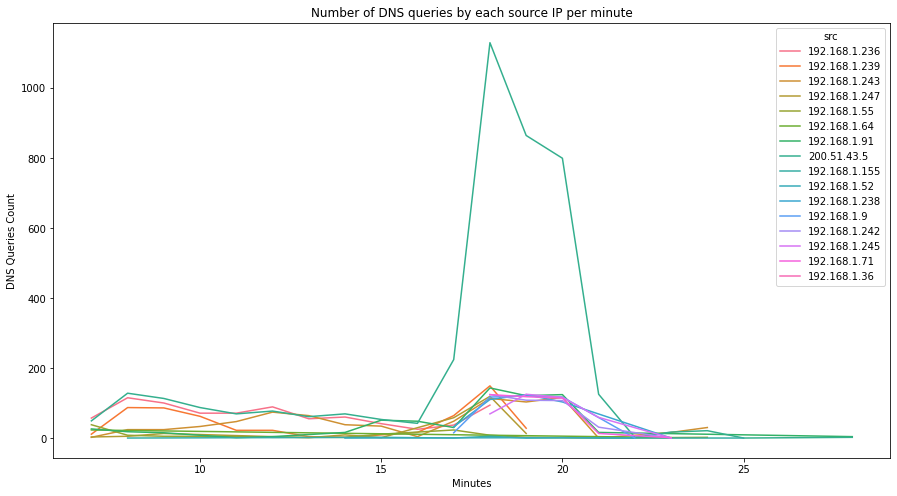

In [ ]:
plt.figure(figsize=[15, 8])
sns.lineplot(data=table2, x='time', y='dnsQueries_count', hue='src', )
plt.title('Number of DNS queries by each source IP per minute')
plt.xlabel('Minutes')
plt.ylabel('DNS Queries Count')